In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

In [4]:
def convert(df):
    mapping = {
        "yes": 1, "no": 0,
        "high": 2, "low": 1, "none": 0
    }
    
    for col in df.iloc[:, :12].columns:
        df[col] = df[col].map(mapping).fillna(df[col])  # Giữ nguyên giá trị nếu không có trong mapping
    
    return df

In [ ]:
cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

### File train 8000
train_df = pd.read_pickle('../../data/train_8000_final.p')
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')  

### File test 2000
test_df = pd.read_pickle('../../data/test_2000_final.p')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')  

train_df = convert(train_df)
test_df = convert(test_df)

# Tạo nhãn kết hợp từ hai cột pneu và cold
count_values = train_df[['pneu', 'inf']].astype(str).agg('-'.join, axis=1)

# Kiểm tra số lượng mẫu mỗi nhóm nhãn
print(count_values.value_counts())




0-0    6057
0-1    1856
1-0      56
1-1      31
Name: count, dtype: int64


In [6]:
train_df.iloc[:,:12]

,asthma,smoking,COPD,winter,hay_fever,pneu,inf,dysp,cough,pain,fever,nasal
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,1,1,0,1
2,0,0,0,1,0,0,1,0,1,0,1,1
3,0,0,0,1,0,0,1,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,0,0,0,0,0,0,0,0,0,0,0
7996,0,0,0,0,0,0,0,1,0,0,0,0
7997,0,0,0,0,0,0,1,0,0,0,0,1
7998,0,0,0,0,0,0,1,0,1,0,0,1


In [7]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

#background: season, policy, self-empl
#diagnosis: pneu, cold
#underlying condition: asthma, smoking, COPD
#symptoms: dyspnea, cough, pain, fever, nasal

BN = BayesianNetwork([
    ('smoking', 'COPD'),
    ('smoking', 'cough'),
    ('smoking', 'dysp'),
    ('asthma', 'dysp'),
    ('asthma', 'pneu'),
    ('asthma', 'cough'),
    ('hay_fever', 'dysp'),
    ('hay_fever', 'nasal'),
    ('COPD', 'pneu'),
    ('COPD', 'dysp'),
    ('COPD', 'cough'),
    ('COPD', 'pain'),
    ('winter', 'pneu'),
    ('winter', 'inf'),
    ('pneu', 'dysp'),
    ('pneu', 'cough'),
    ('pneu', 'pain'),
    ('pneu', 'fever'),
    ('inf', 'cough'),
    ('inf', 'pain'),
    ('pneu', 'fever'),
    ('pneu', 'nasal'),
    ('cough', 'pain'),
    #('policy','antibiotics'),
    #('self_empl','days_at_home')
])

def BN_model_train(train_df, test_df, target):
    print(f"🔹 Đang chạy với target: {target}")

    # Chuyển đổi nhãn thành 0 và 1
    train_df[target] = train_df[target]
    test_df[target] = test_df[target]

    # Huấn luyện mô hình
    BN.fit(train_df, estimator=BayesianEstimator)

    # Khởi tạo suy diễn
    inference = VariableElimination(BN)

    # Dự đoán trên tập test
    test_features = test_df.drop(columns=[target])
    y_true = test_df[target].values
    y_pred = np.array([
        inference.query(variables=[target], evidence=row.to_dict()).values[1]  
        for _, row in test_features.iterrows()
    ])

    # Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Vẽ đồ thị
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()

    return BN

🔹 Đang chạy với target: pneu


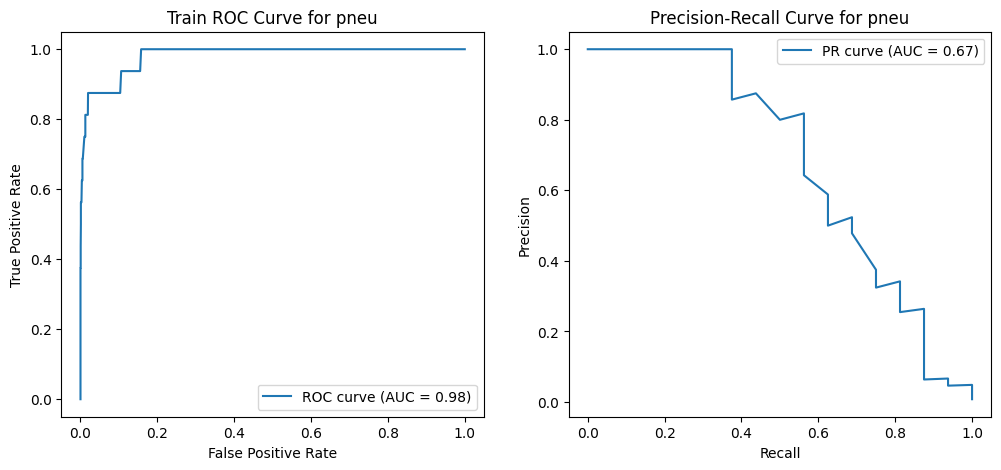

🔹 Đang chạy với target: inf


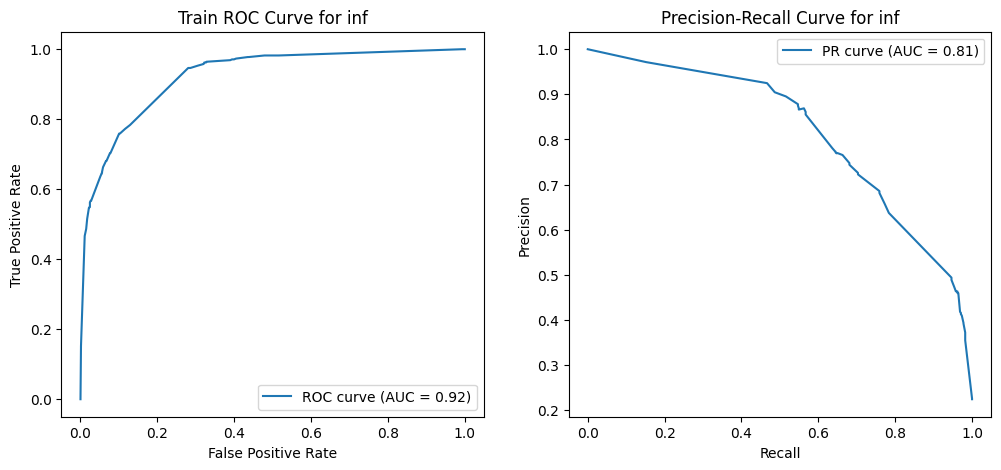

In [8]:
targets = ["pneu", "inf"]
BN_models = {
    'pneu': BN_model_train(train_df.iloc[:,:12], test_df.iloc[:,:12], "pneu"),
    'inf': BN_model_train(train_df.iloc[:,:12], test_df.iloc[:,:12], "inf")
}

In [9]:
train_df = train_df.drop(columns=['inf', 'hist_emb'])
test_df = test_df.drop(columns=['inf', 'hist_emb'])

In [10]:
import shap
inference = VariableElimination(BN_models['inf'])

# 6. Hàm dự đoán đầu ra của Bayesian Network cho LIME
def predict_proba(X):
    probs = []
    for _, row in X.iterrows():
        evidence = row.to_dict()
        query = inference.query(variables=['inf'], evidence=evidence, show_progress=False)
        
        prob_array = np.array(query.values, dtype=np.float64).flatten()  # Ép về float64
        probs.append(prob_array)

    return np.vstack(probs)  

explainer = shap.Explainer(predict_proba, test_df)

# 5. Tính giá trị SHAP
shap_values = explainer(test_df)

PermutationExplainer explainer: 2001it [5:28:01,  9.84s/it]


In [11]:
print(shap_values.output_names)  # Kiểm tra tên nhãn nếu có

['Output 0', 'Output 1']


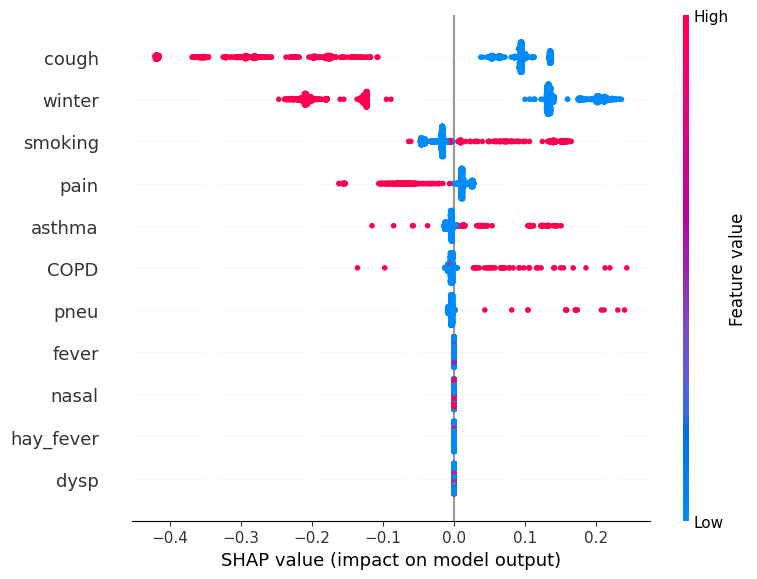

In [ ]:
# inf = no
shap_values_class0 = shap_values.values[..., 0]  # Chọn lớp thứ 2 (index = 1)
shap.summary_plot(shap_values_class0, test_df.to_numpy(), feature_names=test_df.columns.tolist())

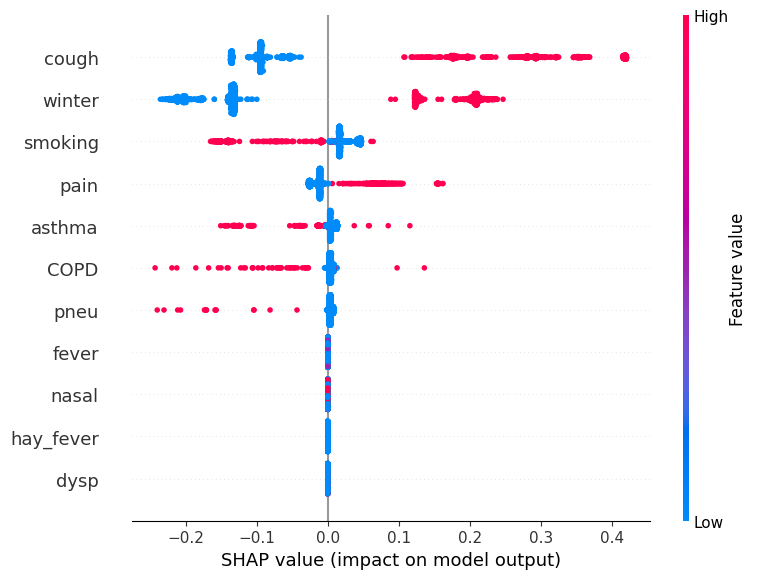

In [ ]:
# inf = yes
shap_values_class1 = shap_values.values[..., 1]  # Chọn lớp thứ 2 (index = 1)
shap.summary_plot(shap_values_class1, test_df.to_numpy(), feature_names=test_df.columns.tolist())